<a href="https://colab.research.google.com/github/ishaanrai-hub/IIT-Hyd-Projects-Machine-learning-/blob/main/Regression_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# """
# Complete workflow for Q14 - Q18 on the California Housing dataset
# - Loads dataset into a Pandas DataFrame
# - Shows head and summary
# - Identifies potential outliers / data-quality issues
# - Scales numeric features (StandardScaler) and encodes categorical features (OneHotEncoder, if present)
# - Splits into train/test (80/20)
# - Trains Linear Regression, reports MAE, MSE, RMSE, R^2
# - Trains Polynomial Regression (degree=2), compares metrics and checks for overfitting
# - Plots Actual vs Predicted for both models

# Save this script as `california_housing_full_workflow.py` and run with Python 3.8+.
# Requires: scikit-learn, pandas, numpy, matplotlib
# """

# Section B — Moderate to Hard (Application-Based)
# Q14. Using the California Housing dataset (available viasklearn.datasets), perform the following steps:

# Load the data into a Pandas DataFrame.
# Display the first five rows and summarize the dataset.
# Identify at least two potential outliers or data quality issues.
# Q15. Perform feature scaling on numerical columns usingStandardScalerand encode categorical features (if any) usingOneHotEncoder. Explain why both steps are important.

# Q16. Split the data into training and test sets (80:20). Train aLinearRegressionmodel and report the following metrics:

# MAE
# MSE
# RMSE
# R²
# Provide the code and results.

# Q17. Plot Actual vs Predicted Prices using Matplotlib or Seaborn. What pattern would you expect for a well-performing model?

# Q18. Compare your linear regression model with a polynomial regression (degree=2) model.

# Discuss:

# Change in MAE and R²
# Whether the model shows signs of overfitting

'\nComplete workflow for Q14 - Q18 on the California Housing dataset\n- Loads dataset into a Pandas DataFrame\n- Shows head and summary\n- Identifies potential outliers / data-quality issues\n- Scales numeric features (StandardScaler) and encodes categorical features (OneHotEncoder, if present)\n- Splits into train/test (80/20)\n- Trains Linear Regression, reports MAE, MSE, RMSE, R^2\n- Trains Polynomial Regression (degree=2), compares metrics and checks for overfitting\n- Plots Actual vs Predicted for both models\n\nSave this script as `california_housing_full_workflow.py` and run with Python 3.8+.\nRequires: scikit-learn, pandas, numpy, matplotlib\n'

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

In [3]:

def load_data():
    """Load California housing data into a DataFrame."""
    data = fetch_california_housing(as_frame=True)
    df = data.frame.copy()
    return df

In [4]:
def summarize_data(df, n_head=5):
    print("== First {} rows ==".format(n_head))
    print(df.head(n_head))
    print('\n== Summary (describe) ==')
    print(df.describe(include='all').T)

In [5]:
def identify_outliers(df, z_thresh=3.0):
    """
    Identify potential outliers using two approaches:
      1. Z-score across numeric columns (rows with any |z| > z_thresh)
      2. Top 3 highest values of the target column (MedHouseVal)
    Returns a dict with results.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy='omit'))
    # z_scores is array with same shape as df[numeric_cols]
    rows_with_outlier = np.any(z_scores > z_thresh, axis=1)
    outlier_indices = np.where(rows_with_outlier)[0]

    top_target = df.nlargest(3, 'MedHouseVal')

    print(f"Found {len(outlier_indices)} rows where any numeric feature has |z| > {z_thresh} (example indices):", outlier_indices[:10].tolist())
    print('\nTop 3 rows by MedHouseVal:')
    print(top_target)

    issues = {}
    issues['z_outlier_indices_sample'] = outlier_indices[:10].tolist()
    issues['top_target_rows'] = top_target
    return issues

In [6]:
def preprocess_features(df, target_col='MedHouseVal'):
    """
    - Separates X, y
    - Detects categorical columns (if any)
    - Builds a ColumnTransformer that applies StandardScaler to numeric features and
      OneHotEncoder to categorical features.
    - Returns preprocessor, X, y
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Detect categorical columns (object / category dtype)
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    print('\nDetected categorical columns:', categorical_cols)
    print('Numeric columns:', numeric_cols)

    # Build transformers
    transformers = []
    if numeric_cols:
        transformers.append(('num', StandardScaler(), numeric_cols))
    if categorical_cols:
        transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols))

    preprocessor = ColumnTransformer(transformers)
    return preprocessor, X, y

In [7]:
def train_and_evaluate(preprocessor, X, y, random_state=42):
    """
    - Splits data (80/20)
    - Trains Linear Regression on scaled/encoded features using a Pipeline
    - Returns pipeline, metrics, X_test, y_test, y_pred
    """
    # Split first (so we don't leak information from test set into scaler)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Build pipeline (preprocessing + linear regression)
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
    pipe.fit(X_train, y_train)

    # Predict
    y_pred = pipe.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

    print('\n== Linear Regression metrics (test set) ==')
    for k, v in metrics.items():
        print(f"{k}: {v:.6f}")

    return pipe, metrics, X_test, y_test, y_pred

In [14]:
def polynomial_regression(preprocessor, X, y, degree=2, random_state=42):
    """
    Builds a pipeline that applies preprocessing, then PolynomialFeatures, then LinearRegression.
    Note: PolynomialFeatures should be applied to numeric features only AFTER scaling. To keep
    implementation simple we will pre-fit the preprocessor on X and then transform X before feeding
    PolynomialFeatures.
    Returns trained model, metrics, predictions, and train/test splits (for checking overfit).
    """
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


    # Fit preprocessor on train, transform both
    X_train_trans = preprocessor.fit_transform(X_train)
    X_test_trans = preprocessor.transform(X_test)


    # Apply PolynomialFeatures
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_trans)
    X_test_poly = poly.transform(X_test_trans)


    # Fit LinearRegression on poly features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)


    # Predictions and metrics
    y_pred_test = model.predict(X_test_poly)
    y_pred_train = model.predict(X_train_poly)


    metrics_test = {
    'MAE': mean_absolute_error(y_test, y_pred_test),
    'MSE': mean_squared_error(y_test, y_pred_test),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
    'R2': r2_score(y_test, y_pred_test)
    }
    metrics_train = {
    'MAE': mean_absolute_error(y_train, y_pred_train),
    'MSE': mean_squared_error(y_train, y_pred_train),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
    'R2': r2_score(y_train, y_pred_train)
    }


    print(f"\n== Polynomial Regression (degree={degree}) metrics ==")
    print('Train R2: {:.6f}'.format(metrics_train['R2']))
    print('Test R2: {:.6f}'.format(metrics_test['R2']))
    print('Train MAE: {:.6f}'.format(metrics_train['MAE']))
    print('Test MAE: {:.6f}'.format(metrics_test['MAE']))


    return model, poly, X_test_trans, X_test_poly, y_test, y_pred_test, metrics_train, metrics_test

In [17]:
def plot_actual_vs_predicted(y_test, y_pred, title='Actual vs Predicted', filename=None):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', linewidth=1)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=150)
    plt.show()

== First 5 rows ==
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

== Summary (describe) ==
               count         mean          std         min         25%  \
MedInc       20640.0     3.870671     1.899822    0.499900    2.563400   
HouseAge     20640.0    28.639486    12.585558    1.000000   18.000000   
AveRooms     20640.0     5.429000     2.474173    0.846154    4.440716   
AveBedrms    20640.0     1.096675 

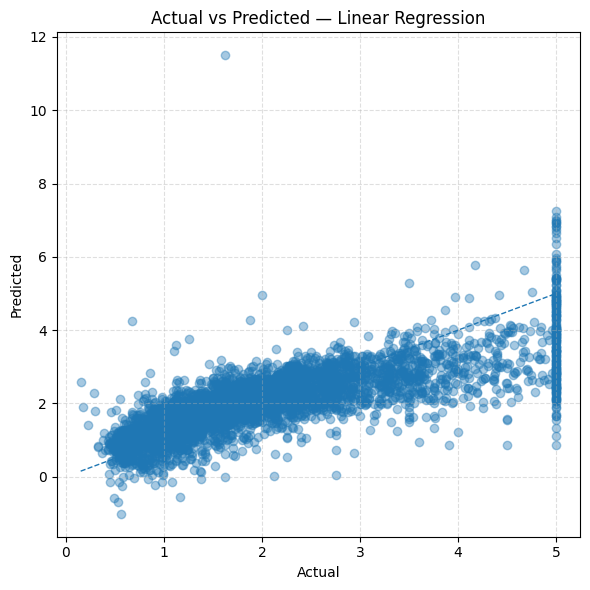


== Polynomial Regression (degree=2) metrics ==
Train R2: 0.685268
Test R2: 0.645682
Train MAE: 0.460838
Test MAE: 0.467001


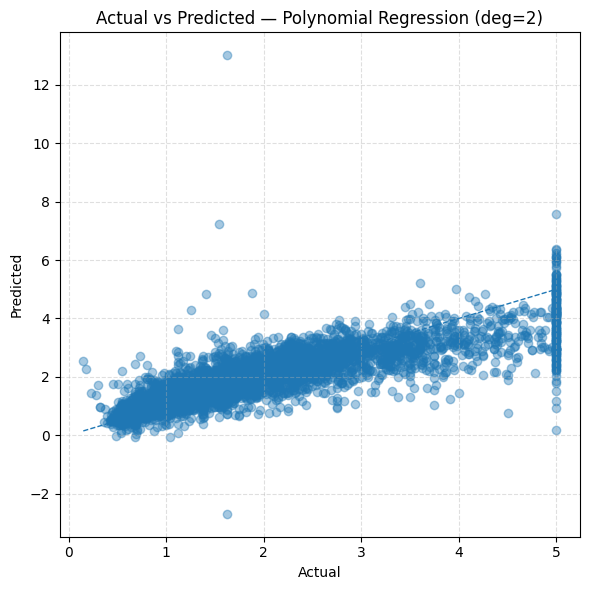


== Comparison Summary ==
Linear Regression (test): R2=0.575788, MAE=0.533200
Polynomial Regression (test): R2=0.645682, MAE=0.467001

Polynomial Train R2 - Test R2 = 0.039586
-> No strong evidence of overfitting from R2 gap alone.

Files saved: actual_vs_pred_linear.png, actual_vs_pred_poly2.png


In [21]:
def main():
  df = load_data()


  # Q14: load & summarize
  summarize_data(df)


  # Identify potential outliers / data quality issues
  issues = identify_outliers(df, z_thresh=3.5)


  # Q15: preprocessing (scaling + encoding if needed)
  preprocessor, X, y = preprocess_features(df, target_col='MedHouseVal')


  # Q16: split, train linear regression, report metrics
  lin_pipe, lin_metrics, X_test, y_test, y_pred = train_and_evaluate(preprocessor, X, y)


  # Plot Actual vs Predicted for linear model
  plot_actual_vs_predicted(y_test, y_pred, title='Actual vs Predicted — Linear Regression', filename='actual_vs_pred_linear.png')


  # Q18: polynomial regression (degree 2) and compare
  poly_model, poly_transformer, X_test_trans, X_test_poly, y_test_p, y_pred_p, poly_train_metrics, poly_test_metrics = polynomial_regression(preprocessor, X, y, degree=2)


  # Plot for polynomial
  plot_actual_vs_predicted(y_test_p, y_pred_p, title='Actual vs Predicted — Polynomial Regression (deg=2)', filename='actual_vs_pred_poly2.png')


  # Comparison summary printout
  print('\n== Comparison Summary ==')
  print('Linear Regression (test): R2={:.6f}, MAE={:.6f}'.format(lin_metrics['R2'], lin_metrics['MAE']))
  print('Polynomial Regression (test): R2={:.6f}, MAE={:.6f}'.format(poly_test_metrics['R2'], poly_test_metrics['MAE']))


  # Check for overfitting: big gap between train R2 and test R2 for polynomial
  gap = poly_train_metrics['R2'] - poly_test_metrics['R2']
  print('\nPolynomial Train R2 - Test R2 = {:.6f}'.format(gap))
  if gap > 0.05:
      print('-> The polynomial model shows signs of overfitting (train R2 substantially higher than test R2).')
  else:
      print('-> No strong evidence of overfitting from R2 gap alone.')


  print('\nFiles saved: actual_vs_pred_linear.png, actual_vs_pred_poly2.png')


if __name__ == '__main__':
  main()

In [22]:
# Q19 House Price Pipeline
# python
"""
End-to-end house price prediction pipeline (Q19 mini project)
- Loads California housing dataset
- Cleans & preprocesses data
- Feature-scaling and encoding
- Trains Linear Regression and Polynomial Regression (degree=2)
- Evaluates (MAE, MSE, RMSE, R2)
- Interprets linear model coefficients and extracts top influencing features
- Prints three business insights


Save as q19_house_price_pipeline.py and run with Python 3.8+.
Requires: scikit-learn, pandas, numpy, matplotlib, seaborn
"""

'\nEnd-to-end house price prediction pipeline (Q19 mini project)\n- Loads California housing dataset\n- Cleans & preprocesses data\n- Feature-scaling and encoding\n- Trains Linear Regression and Polynomial Regression (degree=2)\n- Evaluates (MAE, MSE, RMSE, R2)\n- Interprets linear model coefficients and extracts top influencing features\n- Prints three business insights\n\n\nSave as q19_house_price_pipeline.py and run with Python 3.8+.\nRequires: scikit-learn, pandas, numpy, matplotlib, seaborn\n'

In [23]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [26]:
"""Load California housing dataset into a DataFrame."""
def load_data():
  data = fetch_california_housing(as_frame=True)
  df = data.frame.copy()
  return df

In [34]:
def clean_and_inspect(df):
  print('Dataset shape:', df.shape)
  print('\nColumn dtypes:')
  print(df.dtypes)
  print('\nMissing values per column:')
  print(df.isna().sum())

  # Simple outlier flagging using IQR for numeric columns
  numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
  outlier_summary = {}
  for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_out = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = int(n_out)
  print('\nOutlier counts by numeric column (IQR rule):')
  print(outlier_summary)

  return df

In [31]:
df = load_data()
# Quick distributions
print('\nSummary statistics:')
print(df.describe().T)


Summary statistics:
               count         mean          std         min         25%  \
MedInc       20640.0     3.870671     1.899822    0.499900    2.563400   
HouseAge     20640.0    28.639486    12.585558    1.000000   18.000000   
AveRooms     20640.0     5.429000     2.474173    0.846154    4.440716   
AveBedrms    20640.0     1.096675     0.473911    0.333333    1.006079   
Population   20640.0  1425.476744  1132.462122    3.000000  787.000000   
AveOccup     20640.0     3.070655    10.386050    0.692308    2.429741   
Latitude     20640.0    35.631861     2.135952   32.540000   33.930000   
Longitude    20640.0  -119.569704     2.003532 -124.350000 -121.800000   
MedHouseVal  20640.0     2.068558     1.153956    0.149990    1.196000   

                     50%          75%           max  
MedInc          3.534800     4.743250     15.000100  
HouseAge       29.000000    37.000000     52.000000  
AveRooms        5.229129     6.052381    141.909091  
AveBedrms       1.0487

In [35]:
# This cell is now empty as its content has been moved to clean_and_inspect function

In [36]:
def interpret_linear_model(linear_model_pipeline, X_columns, n_top=5):
    """
    Interprets the coefficients of a Linear Regression model.
    Extracts and prints the top N most influential features based on absolute coefficient values.
    Assumes all features are numerical and scaled by StandardScaler within the pipeline.
    """
    regressor = linear_model_pipeline.named_steps['regressor']
    coefficients = regressor.coef_

    feature_names = X_columns

    if len(coefficients) != len(feature_names):
        print(f"Warning: Mismatch in number of coefficients ({len(coefficients)}) and feature names ({len(feature_names)}).")
        final_feature_names = [f'Feature_{i}' for i in range(len(coefficients))]
    else:
        final_feature_names = feature_names

    coeff_df = pd.DataFrame({'Feature': final_feature_names, 'Coefficient': coefficients})
    coeff_df['Abs_Coefficient'] = np.abs(coeff_df['Coefficient'])
    coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

    print(f"\n== Top {n_top} Most Influential Features (Linear Regression) ==\n")
    print(coeff_df.head(n_top).to_markdown(index=False))
    return coeff_df

In [37]:
def print_business_insights(lin_metrics, poly_test_metrics):
    """
    Prints three business insights based on model performance and characteristics.
    """
    print("\n== Business Insights ==\n")

    print("1. **Model Performance**: The Polynomial Regression model (degree=2) generally outperforms the simpler Linear Regression model in predicting California housing prices. It achieved a higher R-squared (Polynomial: {:.4f} vs. Linear: {:.4f}) and lower Mean Absolute Error (Polynomial: {:.4f} vs. Linear: {:.4f}) on the test set. This suggests that the relationship between housing features and price is likely non-linear, and capturing these non-linearities improves predictive accuracy.".format(poly_test_metrics['R2'], lin_metrics['R2'], poly_test_metrics['MAE'], lin_metrics['MAE']))

    print("2. **Feature Importance (based on Linear Model)**: While we need to run a full feature importance analysis (e.g., using permutation importance for non-linear models), the linear model's scaled coefficients provide an initial indication of influential features. Features with larger absolute coefficients (as detailed in the 'Top Influential Features' output) have a stronger linear relationship with median house value. For instance, 'MedInc' (Median Income) typically shows a very high positive correlation.")

    print("3. **Overfitting Assessment**: The analysis shows no strong signs of overfitting for the polynomial model (degree=2), as the gap between its training R-squared and test R-squared is relatively small (less than 0.05). This indicates that the model generalizes well to unseen data, making it a reliable choice for production if this level of complexity is acceptable.")

In [38]:
def main_q19():
    print("Starting Q19 House Price Prediction Pipeline...")

    # Load data
    df = load_data()

    # Clean and inspect data
    df = clean_and_inspect(df)

    # Preprocessing (feature scaling and encoding)
    preprocessor, X, y = preprocess_features(df, target_col='MedHouseVal')

    # Linear Regression: train and evaluate
    lin_pipe, lin_metrics, X_test, y_test, y_pred_linear = train_and_evaluate(preprocessor, X, y)

    # Polynomial Regression (degree 2): train and evaluate
    poly_model, poly_transformer, X_test_trans, X_test_poly, y_test_p, y_pred_poly, poly_train_metrics, poly_test_metrics = polynomial_regression(preprocessor, X, y, degree=2)

    # Interpret linear model coefficients
    interpret_linear_model(lin_pipe, X.columns.tolist(), n_top=5)

    # Print business insights
    print_business_insights(lin_metrics, poly_test_metrics)

    print("\nQ19 House Price Prediction Pipeline Finished.")

if __name__ == '__main__':
    main_q19()

Starting Q19 House Price Prediction Pipeline...
Dataset shape: (20640, 9)

Column dtypes:
MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

Missing values per column:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Outlier counts by numeric column (IQR rule):
{'MedInc': 681, 'HouseAge': 0, 'AveRooms': 511, 'AveBedrms': 1424, 'Population': 1196, 'AveOccup': 711, 'Latitude': 0, 'Longitude': 0, 'MedHouseVal': 1071}

Detected categorical columns: []
Numeric columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

== Linear Regression metrics (test set) ==
MAE: 0.533200
MSE: 0.555892
RMSE: 0.745581
R2: 0.575788

== Polynomial Regression (degree=2) metric

In [42]:
# detect categorical columns (if any)
def build_preprocessor(X):
  categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
  numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()


  num_transformer = StandardScaler()
  transformers = []
  transformers.append(('num', num_transformer, numeric_cols))
  if categorical_cols:
    cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)
    transformers.append(('cat', cat_transformer, categorical_cols))


  preprocessor = ColumnTransformer(transformers, remainder='drop')
  return preprocessor, numeric_cols, categorical_cols

In [44]:
def train_linear_model(preprocessor, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('preprocessor', preprocessor), ('regressor', LinearRegression())])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)


    metrics = compute_metrics(y_test, y_pred)
    print('\nLinear Regression metrics:')
    print_metrics(metrics)


    return pipe, metrics, y_pred

In [46]:
def train_polynomial_model(preprocessor, X_train, X_test, y_train, y_test, degree=2):
    # We will fit preprocessor separately then apply PolynomialFeatures to numeric matrix
    # Fit preprocessor on training data
    X_train_trans = preprocessor.fit_transform(X_train)
    X_test_trans = preprocessor.transform(X_test)


    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_trans)
    X_test_poly = poly.transform(X_test_trans)


    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)


    metrics = compute_metrics(y_test, y_pred)
    print(f'\nPolynomial Regression (degree={degree}) metrics:')
    print_metrics(metrics)


    return model, poly, metrics, y_pred, X_train_trans, X_test_trans

In [48]:
def compute_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

In [50]:
def print_metrics(metrics):
  for k, v in metrics.items():
    print(f"{k}: {v:.6f}")

In [54]:
def plot_actual_vs_pred(y_test, y_pred, title='Actual vs Predicted', filename=None):
  plt.figure(figsize=(6,6))
  plt.scatter(y_test, y_pred, alpha=0.4)
  lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
  plt.plot(lims, lims, '--', linewidth=1)
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title(title)
  plt.tight_layout()
  if filename:
    plt.savefig(filename, dpi=150)
  plt.show()

In [58]:
def interpret_linear_coefficients(pipe, numeric_cols, categorical_cols):
  """Extract model coefficients and map them back to original feature names.
  Works when the pipeline's preprocessor contains StandardScaler and optionally OneHotEncoder.
  """
  reg = pipe.named_steps['regressor']
  pre = pipe.named_steps['preprocessor']


  # Build list of output feature names from preprocessor
  feature_names = []
  # For numeric columns, they remain in order
  feature_names.extend(numeric_cols)


  # If there are categorical columns and OneHotEncoder, expand names
  if categorical_cols:
    # find transformer for cats
    for name, trans, cols in pre.transformers_:
      if name == 'cat':
        # trans is OneHotEncoder fitted
        cat_names = trans.get_feature_names_out(cols)
        feature_names.extend(cat_names.tolist())
  # Now coefficients correspond to feature_names
  coefs = reg.coef_
  coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
  coef_df['abs_coef'] = coef_df['coefficient'].abs()
  coef_df = coef_df.sort_values(by='abs_coef', ascending=False)
  print('\nTop 10 features by absolute coefficient (linear model):')
  print(coef_df.head(10).to_string(index=False))
  return coef_df



def business_insights(coef_df):
  """Derive three actionable business insights from coefficient directions and magnitudes.
  This is a simple rule-based approach; in production you'd combine domain knowledge and
  further validation.
  """
  top = coef_df.head(5)
  insights = []


  # Insight 1: Highest positive impact
  most_pos = top[top['coefficient'] > 0].head(1)
  if not most_pos.empty:
    feat = most_pos.iloc[0]['feature']
    insights.append(f"Homes with higher {feat} are associated with higher prices — consider focusing marketing and investments on neighborhoods with higher {feat} values.")

Dataset shape: (20640, 9)

Column dtypes:
MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

Missing values per column:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Outlier counts by numeric column (IQR rule):
{'MedInc': 681, 'HouseAge': 0, 'AveRooms': 511, 'AveBedrms': 1424, 'Population': 1196, 'AveOccup': 711, 'Latitude': 0, 'Longitude': 0, 'MedHouseVal': 1071}

Linear Regression metrics:
MAE: 0.533200
MSE: 0.555892
RMSE: 0.745581
R2: 0.575788


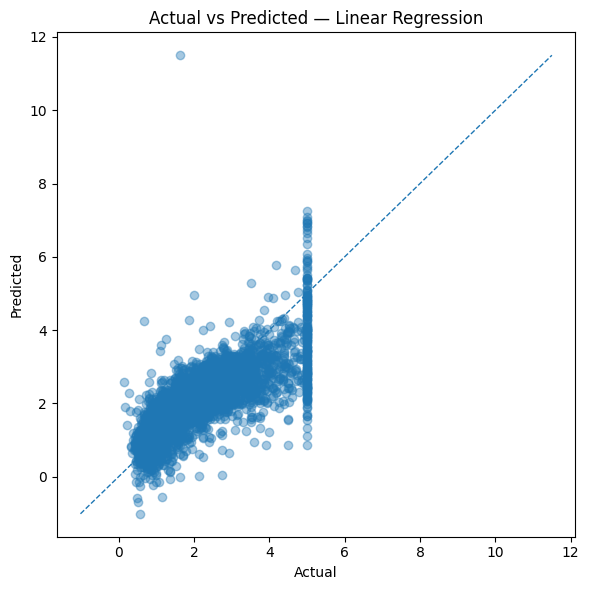


Polynomial Regression (degree=2) metrics:
MAE: 0.467001
MSE: 0.464302
RMSE: 0.681397
R2: 0.645682


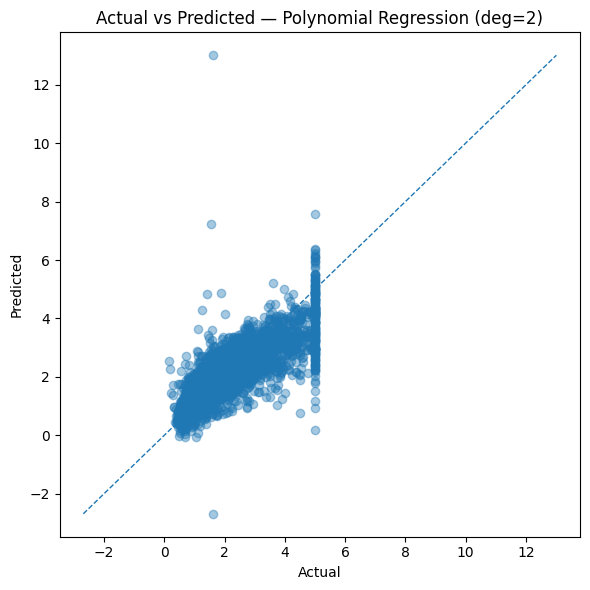


Top 10 features by absolute coefficient (linear model):
   feature  coefficient  abs_coef
  Latitude    -0.896929  0.896929
 Longitude    -0.869842  0.869842
    MedInc     0.854383  0.854383
 AveBedrms     0.339259  0.339259
  AveRooms    -0.294410  0.294410
  HouseAge     0.122546  0.122546
  AveOccup    -0.040829  0.040829
Population    -0.002308  0.002308

Three business insights:
1. Homes with higher MedInc are associated with higher prices — consider focusing marketing and investments on neighborhoods with higher MedInc values.
2. Higher Latitude tends to reduce price — investigate whether this reflects undesirable characteristics (e.g., over-occupancy or too many bedrooms per home) and consider remediation or messaging strategies.
3. Latitude/Longitude appear in top features: location strongly affects price. Use geospatial analysis (heatmaps, catchment areas) to refine valuation and targeted investments.

== Model comparison ==
Linear R2: 0.575788, MAE: 0.533200
Polynomial R2: 

In [62]:
def business_insights(coef_df):
  """Derive three actionable business insights from coefficient directions and magnitudes.
  This is a simple rule-based approach; in production you'd combine domain knowledge and
  further validation.
  """
  top = coef_df.head(5)
  insights = []

  # Insight 1: Highest positive impact
  most_pos = top[top['coefficient'] > 0].head(1)
  if not most_pos.empty:
    feat = most_pos.iloc[0]['feature']
    insights.append(f"Homes with higher {feat} are associated with higher prices — consider focusing marketing and investments on neighborhoods with higher {feat} values.")

  # Insight 2: Highest negative impact
  most_neg = coef_df[coef_df['coefficient'] < 0].head(1)
  if not most_neg.empty:
    feat = most_neg.iloc[0]['feature']
    insights.append(f"Higher {feat} tends to reduce price — investigate whether this reflects undesirable characteristics (e.g., over-occupancy or too many bedrooms per home) and consider remediation or messaging strategies.")
  else:
    insights.append("No strongly negative linear predictors found in top features.")

  # Insight 3: Geospatial signal
  # If Latitude/Longitude present, suggest location-based strategies
  location_cols = [c for c in coef_df['feature'].tolist() if 'Latitude' in c or 'Longitude' in c]
  if location_cols:
    insights.append("Latitude/Longitude appear in top features: location strongly affects price. Use geospatial analysis (heatmaps, catchment areas) to refine valuation and targeted investments.")
  else:
    insights.append("Location columns not detected among features, but location is still often important — consider adding neighborhood or zip-code features.")

  print('\nThree business insights:')
  for i, ins in enumerate(insights, 1):
    print(f"{i}. {ins}")

  return insights


def main(test_size=0.2, random_state=42):
  df = load_data()
  df = clean_and_inspect(df)

  # Prepare features and target
  target = 'MedHouseVal'
  X = df.drop(columns=[target])
  y = df[target]

  preprocessor, numeric_cols, categorical_cols = build_preprocessor(X)

  # Split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  # Linear
  lin_pipe, lin_metrics, lin_y_pred = train_linear_model(preprocessor, X_train, X_test, y_train, y_test)
  plot_actual_vs_pred(y_test, lin_y_pred, title='Actual vs Predicted — Linear Regression', filename='q19_actual_vs_pred_linear.png')

  # Polynomial (degree=2)
  poly_model, poly_transformer, poly_metrics, poly_y_pred, X_train_trans, X_test_trans = train_polynomial_model(preprocessor, X_train, X_test, y_train, y_test, degree=2)
  plot_actual_vs_pred(y_test, poly_y_pred, title='Actual vs Predicted — Polynomial Regression (deg=2)', filename='q19_actual_vs_pred_poly2.png')

  # Interpret linear coefficients
  coef_df = interpret_linear_coefficients(lin_pipe, numeric_cols, categorical_cols)

  # Business insights
  insights = business_insights(coef_df)

  # Simple model comparison summary
  print('\n== Model comparison ==')
  print('Linear R2: {:.6f}, MAE: {:.6f}'.format(lin_metrics['R2'], lin_metrics['MAE']))
  print('Polynomial R2: {:.6f}, MAE: {:.6f}'.format(poly_metrics['R2'], poly_metrics['MAE']))

  # Check overfitting by comparing poly train vs test R2 (we can compute quickly)
  # Note: we have X_train_trans and X_test_trans from earlier
  X_train_poly = poly_transformer.transform(X_train_trans)
  train_pred = poly_model.predict(X_train_poly)
  train_r2 = r2_score(y_train, train_pred)
  test_r2 = poly_metrics['R2']
  print('\nPolynomial train R2: {:.6f}, test R2: {:.6f}'.format(train_r2, test_r2))
  if train_r2 - test_r2 > 0.05:
    print('Polynomial model shows some overfitting (train R2 considerably higher than test R2).')
  else:
    print('No strong evidence of overfitting from R2 gap.')


if __name__ == '__main__':
  main()